In [39]:
import numpy as np
import matplotlib.pyplot as plt
import random

import os
import json
import time

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import torch

import sys
sys.path.append("..")
import config

from tokenizer.tokenizer import ByteLevelBPE, TokenizerHF

import importlib

from model.CPTR_upd import CPTR

from model.helpers import *

from dataset.loader import DatasetLoader

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

In [40]:
importlib.reload(config)

<module 'config' from '/home/nad/studies/Transformer-Image-Captioning-IIW/visualization/../config.py'>

In [41]:
device = "cpu"

model_path = '../results/cptr_model_20260119-194814.pth'

In [42]:
data_loader = DatasetLoader(dataset_type=config.DATASET, batch_size_train=config.BATCH_SIZE_TRAIN, batch_size_test=config.BATCH_SIZE_TEST, shuffle_test=True)
data_loader.load_data()

train_dataloader = data_loader.get_train_dataloader()
test_dataloader = data_loader.get_test_dataloader()

special_tokens = [config.SpecialTokens.PAD, config.SpecialTokens.BOS, config.SpecialTokens.EOS]
if config.TOKENIZER_TYPE == config.TokenizerType.HF:
    tokenizer = TokenizerHF()
elif config.TOKENIZER_TYPE == config.TokenizerType.BPE:
    tokenizer = ByteLevelBPE(special_tokens=special_tokens)
    tokenizer.load(folder=config.TOKENIZER_DATA_PATH, filename_prefix=config.TOKENIZER_FILENAME_PREFIX)

pad_idx = tokenizer.get_padding_token_id()
vocab_size = tokenizer.get_vocab_size()

Loading COCO dataset...


In [43]:
transformer = CPTR(num_patches=config.NUM_PATCHES,
                   img_emb_dim=config.IMG_EMBEDDING_DIM,
                   patch_size=config.PATCH_SIZE,
                   text_emb_dim=config.TEXT_EMBEDDING_DIM,
                   d_model=config.EMBEDDING_DIM,
                   max_text_seq_len=config.MAX_TEXT_SEQUENCE_LENGTH,
                   vocab_size=vocab_size,
                   pad_idx=pad_idx,
                   verbose=False).to(device)
transformer.load_state_dict(torch.load(model_path, map_location=device))
transformer.eval()

if config.ENCODER_ARCH == config.EncoderArch.VIT_STYLE_BASE or config.ENCODER_ARCH == config.EncoderArch.VIT_STYLE_LARGE:
    model = transformer.encoder
else:
    raise ValueError(f'Unsupported encoder architecture for visualization: {config.ENCODER_ARCH}')

Initialized ViT Encoder: google/vit-base-patch16-224-in21k


In [44]:
print(model.vit.encoder)

ViTEncoder(
  (layer): ModuleList(
    (0-11): 12 x ViTLayer(
      (attention): ViTAttention(
        (attention): ViTSelfAttention(
          (query): Linear(in_features=768, out_features=768, bias=True)
          (key): Linear(in_features=768, out_features=768, bias=True)
          (value): Linear(in_features=768, out_features=768, bias=True)
        )
        (output): ViTSelfOutput(
          (dense): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (intermediate): ViTIntermediate(
        (dense): Linear(in_features=768, out_features=3072, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): ViTOutput(
        (dense): Linear(in_features=3072, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (layernorm_before): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (layernorm_after): LayerNorm((768,), eps=1e-12, elementwise_a

In [45]:
for layer in model.vit.encoder.layer:
  layer.attention.attention.fused_attn = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].


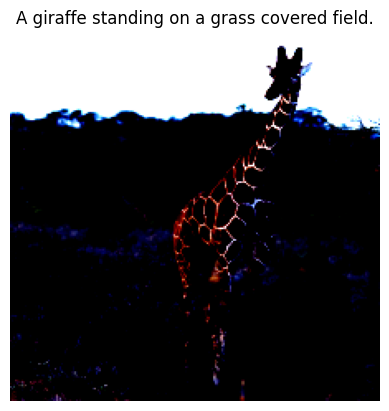

In [46]:
batch = next(iter(train_dataloader))
img_tensor = batch['pixel_values'][0].unsqueeze(0).to(device)
description = batch['description'][0]

# plot
img = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
plt.imshow(img)
plt.axis('off')
plt.title(description)
plt.show()

In [47]:
_, attn = model(img_tensor, return_attn=True)
for block in attn: # len(attn) == 12 (num of layers)
    print(block.shape)  # (batch_size, num_heads, seq_len, seq_len)

torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])
torch.Size([1, 12, 197, 197])


In [48]:
attn_last = attn[-1]          # only need last layer
attn_last_mean = attn_last.mean(dim=1)  # average heads → [B, 197, 197]
cls_attn = attn_last_mean[:, 0, 1:]      # [B, 196]
cls_attn_map = cls_attn.reshape(cls_attn.shape[0], 14, 14)

patch_attn = attn_last_mean[:, 1:, 1:]  # [B, 196, 196]
patch_saliency = patch_attn.sum(dim=1)  # [B, 196]
patch_saliency_map = patch_saliency.reshape(patch_saliency.shape[0], 14, 14)
patch_attn_map = patch_attn.reshape(patch_attn.shape[0], 14, 14, 14, 14).mean(dim=(3,4))  # [B, 14, 14]

# individual attention maps
maps_cls = []
for attn_head in attn_last[0]:  # attn_last: [B, num_heads, seq_len, seq_len]
    cls_attn_head = attn_head[0, 1:]  # [196]
    cls_attn_map_head = cls_attn_head.reshape(14, 14)
    maps_cls.append(cls_attn_map_head.detach().cpu())

maps_patch = []
for attn_head in attn_last[0]:  # attn_last: [B, num_heads, seq_len, seq_len]
    patch_attn_head = attn_head[1:, 1:]  # [196, 196]
    patch_siliency_head = patch_attn_head.sum(dim=0)  # [196]
    patch_siliency_map_head = patch_siliency_head.reshape(14, 14)
    maps_patch.append(patch_siliency_map_head.detach().cpu())

In [49]:
cls_attn_map = torch.nn.functional.interpolate(
    cls_attn_map.unsqueeze(1),
    size=(config.IMG_HEIGHT, config.IMG_WIDTH),
    mode="bilinear",
    align_corners=False
).squeeze(1)

patch_attn_map = torch.nn.functional.interpolate(
    patch_attn_map.unsqueeze(1),
    size=(224, 224),
    mode="bilinear",
    align_corners=False
).squeeze(1)

patch_saliency_map = torch.nn.functional.interpolate(
    patch_saliency_map.unsqueeze(1),
    size=(224, 224),
    mode="bilinear",
    align_corners=False
).squeeze(1)

maps_processed_cls = []
for map in maps_cls:
    map = torch.nn.functional.interpolate(
        map.unsqueeze(0).unsqueeze(0),
        size=(224, 224),
        mode="bilinear",
        align_corners=False
    ).squeeze(0).squeeze(0)
    maps_processed_cls.append(map.detach().numpy())

maps_processed_patch = []
for map in maps_patch:
    map = torch.nn.functional.interpolate(
        map.unsqueeze(0).unsqueeze(0),
        size=(224, 224),
        mode="bilinear",
        align_corners=False
    ).squeeze(0).squeeze(0)
    maps_processed_patch.append(map.detach().numpy())

## CLS Attention Map - Global Aggregation Map

* Effectively visualizing:
    $$ A_{CLS \to patch} \in \mathbb{R}^{196} $$

* Answers the question: "Which patches does the global token attend to when forming a global representation?"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].


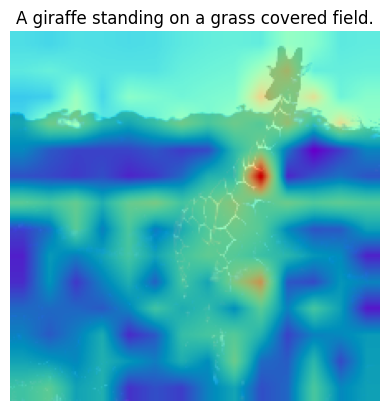

In [50]:
plt.imshow(img)
plt.imshow(cls_attn_map[0].detach().cpu(), alpha=0.8, cmap="rainbow")
plt.title(description)
plt.axis("off")
plt.show()

## Patch Attention Map - Self-Attention among Patches

* Effectively visualizing:
    $$ A_{patch \to patch} \in \mathbb{R}^{196 \times 196} $$

* Answers the questions: 
  * "How strongly do patches attend to each other?" (`patch_attn_map`)
  * "Which patches are globally influential in the learned image representation?" (`patch_saliency_map`)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].


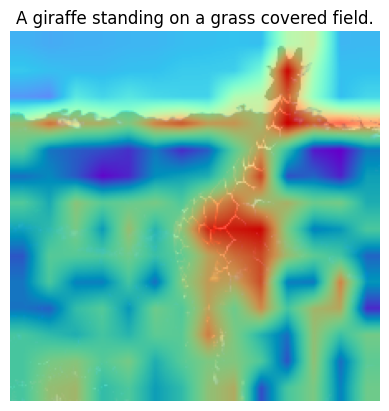

In [51]:
plt.imshow(img)
plt.imshow(patch_saliency_map[0].detach().cpu(), alpha=0.8, cmap="rainbow")
plt.title(description)
plt.axis("off")
plt.show()

## CLS Attention Map per Head

In [52]:
# grid of attention heads
num_heads = len(maps_processed_cls)
grid_size = int(np.ceil(np.sqrt(num_heads)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.100779

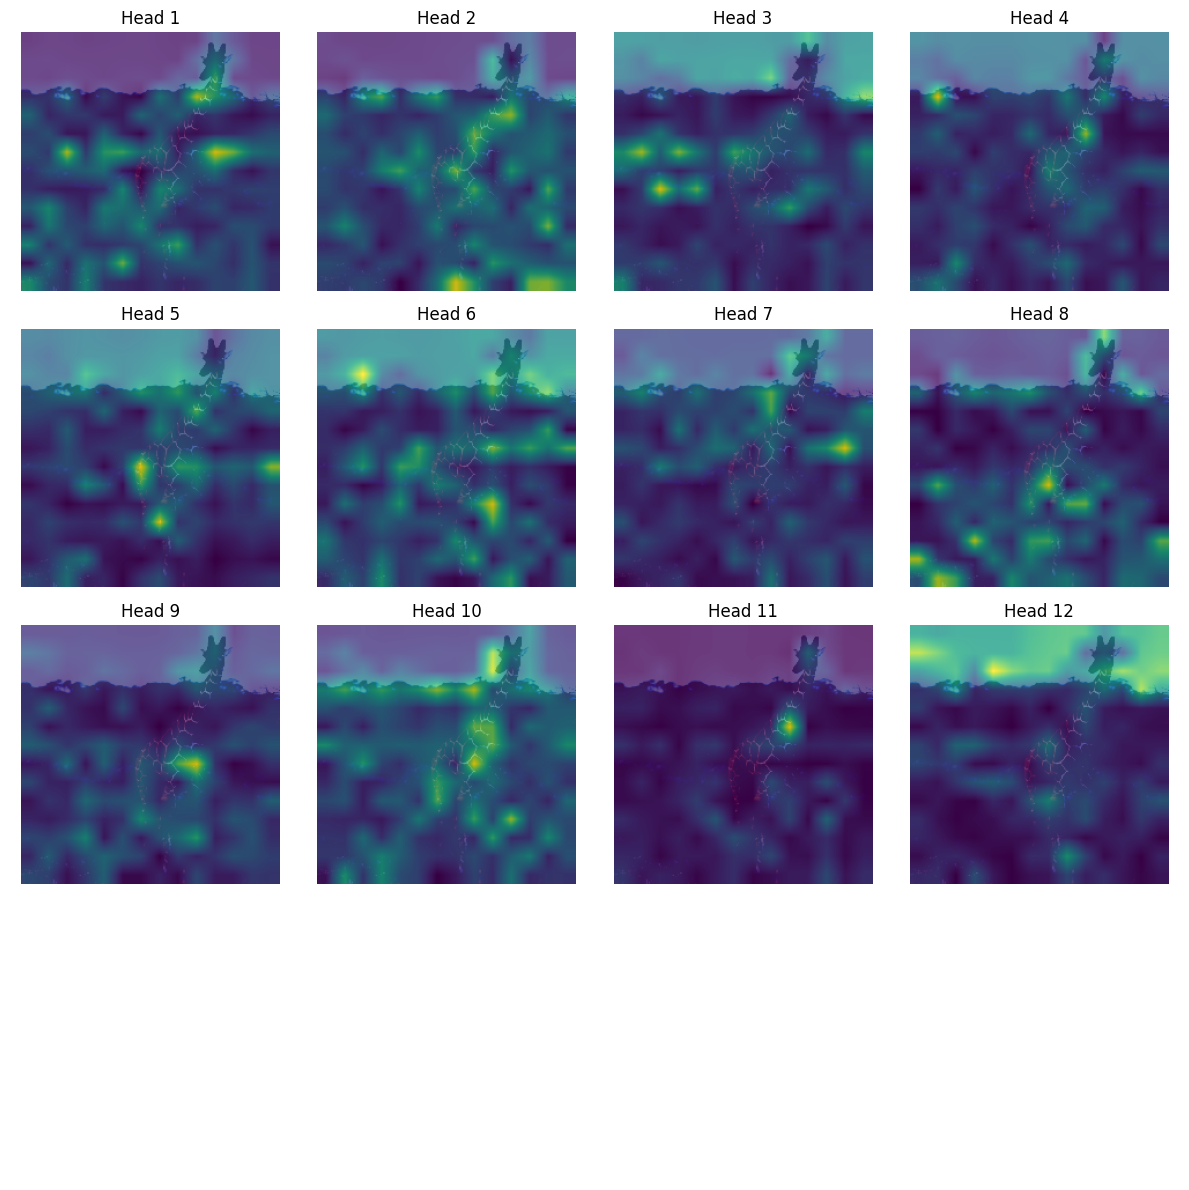

In [53]:
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
for i in range(grid_size):
    for j in range(grid_size):
        ax = axes[i, j]
        head_idx = i * grid_size + j
        if head_idx < num_heads:
            ax.imshow(img)
            ax.imshow(maps_processed_cls[head_idx], alpha=0.8, cmap="viridis")
            ax.set_title(f'Head {head_idx+1}')
        ax.axis("off")
plt.tight_layout()
plt.show()

## Patch Attention Map per Head

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.100779

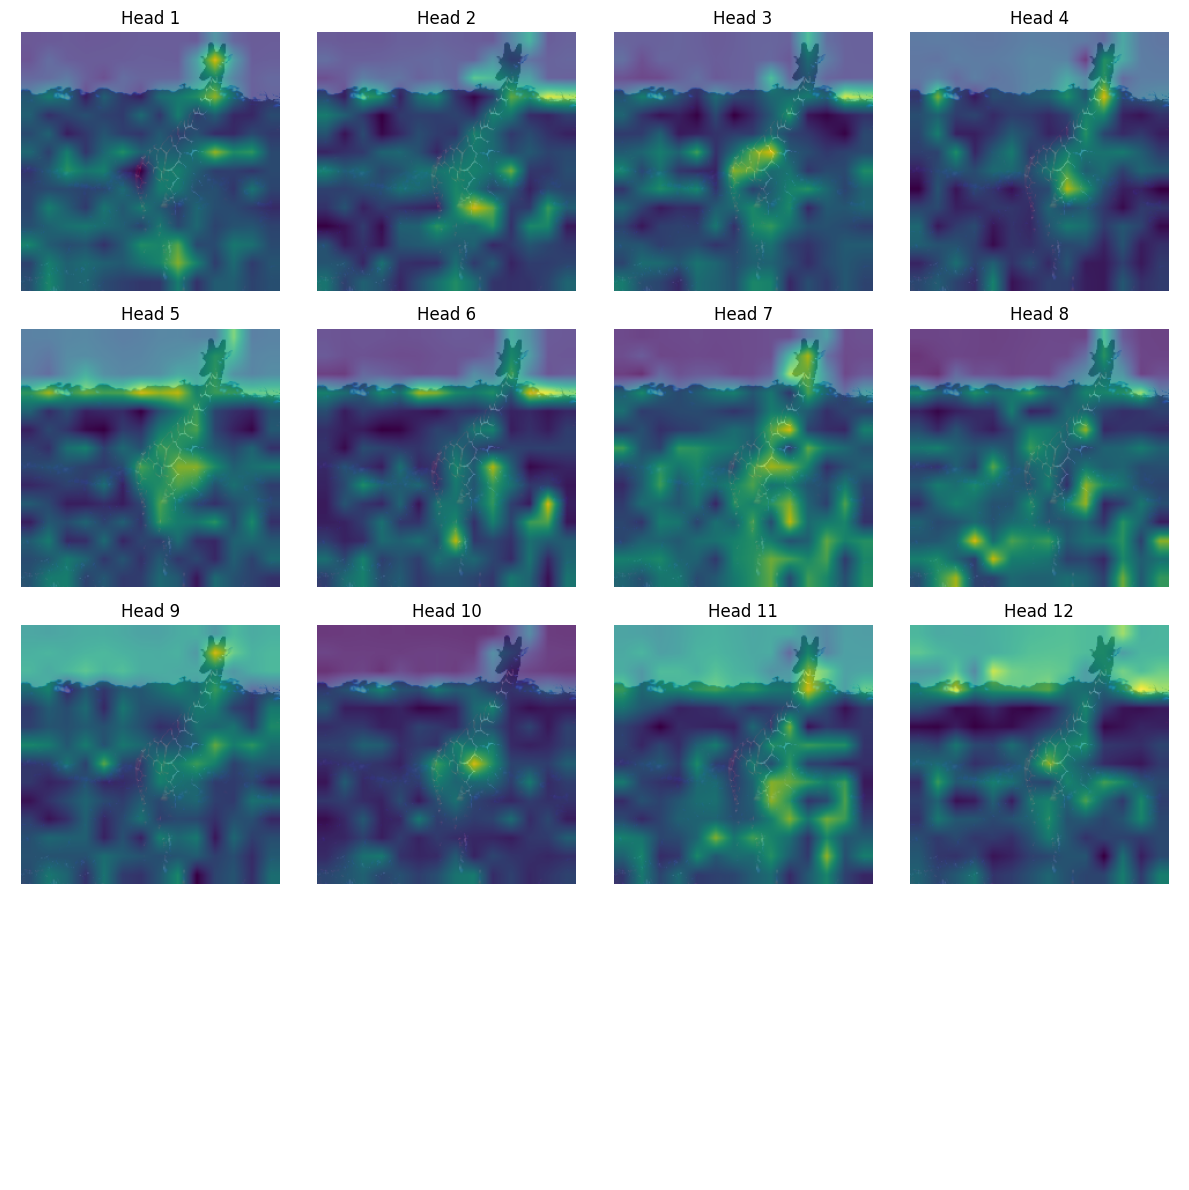

In [54]:
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
for i in range(grid_size):
    for j in range(grid_size):
        ax = axes[i, j]
        head_idx = i * grid_size + j
        if head_idx < num_heads:
            ax.imshow(img)
            ax.imshow(maps_processed_patch[head_idx], alpha=0.8, cmap="viridis")
            ax.set_title(f'Head {head_idx+1}')
        ax.axis("off")
plt.tight_layout()
plt.show()